## Linear regression analysis for GOOGLE Stock

Import the required libraries. Quandl module consists of the financial and economic datasets. We use this module to import the **GOOGL** stock dataset.

In [150]:
import pandas as pd
import quandl, math, datetime
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [84]:
df = quandl.get('WIKI/GOOGL')
#Peek into the first 5 rows 
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


**Adj** features are important since it factors in anything that might happen to the stock after market close. Create a list of those features and retain them in the df

In [85]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [86]:
#Lets create a new column HL_percent to find out the percent change in the Adj.high and Adj.close.
df['HL_pcnt'] = (df['Adj. High'] - df['Adj. Close'])/df['Adj. Close'] *100.0

#Create another column to find out the percent change of the stock price on a daily basis
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open'] *100.0

df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_pcnt,PCT_change
Date,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,3.712563,0.324968
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,0.710922,7.227007
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,3.729433,-1.227880
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,6.417469,-5.726357
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,1.886792,1.183658


Consider the important features as follows:
* **Adj.Close** : Closing price of the stock
* **HL_pcnt** percent change of high stock price and closing
* **PCT_change** percent change in the stock price end of market
* **Adj. Volume** volume of the stock transactions

In [87]:
df = df[['Adj. Close', 'HL_pcnt', 'PCT_change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_pcnt,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


Lets assume that we are building a model to predict the stock price 1% of date into the future. For example the length of our dataset is 3424, 1% of 3424 is 34.34. Using math.ceil we round up the value to be 35. The first stock's life starts on 08/19 and its "predicted" label value is the Adj. Close 35 days after 08/19. This is how the label column is created. We dropna values so the we avoid the value with label Nan. 

In [88]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace = True)

In [89]:
forecast_out = int(math.ceil(0.01* len(df)))

In [90]:
#shift(-forecast_out) moves the Adj. close value from bottom to top by 35 rows. 
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace = True)
# 08/19 label is 69.078238 which is the Adj.Close on 10/08 (35 days later)
df.head(n = 5)

,Adj. Close,HL_pcnt,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849


In [103]:
df.shape

(3389, 5)

In [120]:
#create an array of features by cutting out label
X = np.array(df.drop(['label'], 1))
#preprocess the X data
X = preprocessing.scale(X)
#create X_lately whose label needs to be predicted. X_lately is basically the last 35 rows in df which doesn't have
#label since label is the Adj.Close 35 days out. 
X = X[:-forecast_out]
X_lately = X[-forecast_out:]


df.dropna(inplace = True)
y = np.array(df['label'])

(3354, 4) (35, 4) (3389,)


array([1148.89, 1150.61, 1134.42, 1100.07, 1095.8 , 1094.  , 1053.15,
       1026.55, 1054.09, 1006.94])

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [99]:
regressor.score(X_test, y_test)

0.9773794727778184

In [121]:
clf = LinearRegression(n_jobs = -1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
confidence

0.9773408914436944

In [124]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

In [140]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
print(next_unix)

1517875200.0


In [141]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

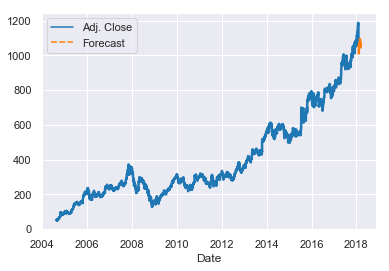

In [164]:
ax = sns.lineplot(data=df[['Adj. Close', 'Forecast']], palette="tab10", linewidth=2.5)